In [ ]:
!pip install d2l

In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 1 RNN from Scracth
![avatar](figure1.png)
![avatar](figure2.png)

In [2]:
class RNNScratch(nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma=sigma
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
      if state is None:
          # Initial state with shape: (batch_size, num_hiddens)
          state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
      else:
          state, = state
      outputs = []
      for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
          state = torch.tanh(torch.matmul(X, self.W_xh) +
                          torch.matmul(state, self.W_hh) + self.b_h)
          outputs.append(state)
      return outputs, state

In [3]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [4]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

# 2 RNN as Language Model
![avatar](figure4.png)
![avatar](figure5.png)

In [5]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
      outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
      return torch.stack(outputs, 1)

    def forward(self, X, state=None):
      embs = self.one_hot(X)
      rnn_outputs, _ = self.rnn(embs, state)
      return  self.output_layer(rnn_outputs)


In [6]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## Gradient Clip
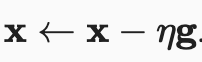

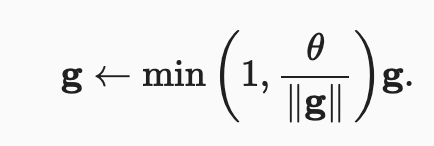

In [7]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

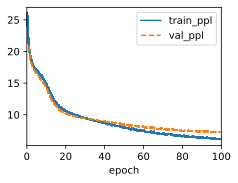

In [8]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

![avatar](figure6.png)

In [9]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '

In [11]:
model.predict('why', 20, data.vocab, d2l.try_gpu())

'why the the the the the'

# 3 RNN Model Usage

In [12]:
class RNN(d2l.Module):
    """The RNN model implemented with Pytorch."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens)# https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [13]:
class RNNLM(d2l.RNNLMScratch):
    '''The RNN-based language model implemented with Pytorch.'''
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size) # https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html#torch.nn.LazyLinear

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [14]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


'it has wwwwwwwwwwwwwwwwwww'

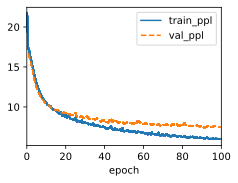

In [15]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

![avatar](figure3.png)

In [16]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the that the tr'

In [17]:
model.predict('why', 30, data.vocab, d2l.try_gpu())

'why the traveller and the that th'